In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import urllib3
import html5lib
import regex as re
import datetime as dt
import time

In [2]:
url = 'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', id = 'per_game_stats')
per_game_stats = pd.read_html(str(table))[0]

In [3]:
table = soup.find_all('table')

In [4]:
url = 'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
# ids: totals_stats, per_game_stats, per_minute_stats, per_poss_stats, advanced_stats, pbp_stats, shooting_stats, adj-shooting
table = soup.find('table', id='per_game_stats')
stats = pd.read_html(str(table))[0]

In [5]:
stats.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,...,.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,2,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,...,.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,3,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,...,.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,4,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,...,.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,5,Santi Aldama,PF,22,MEM,77,20,21.8,3.2,6.8,...,.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0


# Get Player Ids

In [6]:
#get player ids/links to each player page
url = 'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', id='per_game_stats')

In [7]:
#code from https://github.com/rd11490/NBA_Tutorials/blob/master/deduplicating_sources/scrape_bbref.py
# note to refactor later and try to come up with own
def parse_row(row):
    other_data = row.find_all("td")
    if len(other_data) == 0:
        return []
    id = other_data[0].find_all("a")[0]["href"].replace("/players/", "").replace(".html","").split("/")[-1]
    row_data = [td.string for td in other_data]
    row_data.append(id)
    return row_data

def extract_column_names(table):
    columns = [col["aria-label"] for col in table.find_all("thead")[0].find_all("th")][1:]
    columns.append("id")
    return columns

players_columns=extract_column_names(table)
rows = table.find_all("tbody")[0].find_all("tr")
parsed_rows = []
for r in rows:
    parsed = parse_row(r)
    if len(parsed) > 0:
        parsed_rows.append(parsed)

In [8]:
players_list = pd.DataFrame(parsed_rows, columns=players_columns)
players_list[['Player','id']]

,Player,id
0,Precious Achiuwa,achiupr01
1,Steven Adams,adamsst01
2,Bam Adebayo,adebaba01
3,Ochai Agbaji,agbajoc01
4,Santi Aldama,aldamsa01
...,...,...
674,Thaddeus Young,youngth01
675,Trae Young,youngtr01
676,Omer Yurtseven,yurtsom01
677,Cody Zeller,zelleco01


# Player Game Log Filter Chart

In [9]:

# Pulling Game Logs for one player
player_name='Tyrese Haliburton'
urlid= str(players_list.loc[players_list['Player'] == player_name]['id'].values).replace("['","").replace("']","")
url= "https://www.basketball-reference.com/players/h/halibty01/gamelog/2023"
url = f"https://www.basketball-reference.com/players/{urlid[0]}/{urlid}/gamelog/2023"
response = requests.get(url)
soup = BeautifulSoup(response.content,'html.parser')
table = soup.find_all('table',id = 'pgl_basic')

In [10]:
# Pulling Game Logs for all players from a season (2022-2023)
playerids = players_list[['Player','id']]
game_logs=pd.DataFrame()
i=0
for i in range(len(playerids)):
    name = playerids['id'][i]
    url = f"https://www.basketball-reference.com/players/{name[0]}/{name}/gamelog/2023"
    response = requests.get(url)
    time.sleep(2)
    soup = BeautifulSoup(response.content,'html.parser')
    table = soup.find_all('table', id = 'pgl_basic')
    df = pd.read_html(str(table))[0]
    df['Player']=playerids['Player'][i]
    game_logs = game_logs.append( df, ignore_index=True)

In [11]:
game_logs.head()

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player
0,1,1,2022-10-19,23-030,TOR,NaN,CLE,W (+3),0,17:56,...,5,0,0,0,0,1,10,5.0,-4,Precious Achiuwa
1,2,2,2022-10-21,23-032,TOR,@,BRK,L (-4),0,17:29,...,6,0,0,0,3,2,4,-2.2,-8,Precious Achiuwa
2,3,3,2022-10-22,23-033,TOR,@,MIA,L (-3),0,33:32,...,11,1,0,0,1,1,18,17.1,+16,Precious Achiuwa
3,4,4,2022-10-24,23-035,TOR,@,MIA,W (+8),0,33:43,...,22,2,0,1,0,2,10,12.7,+10,Precious Achiuwa
4,5,5,2022-10-26,23-037,TOR,NaN,PHI,W (+10),0,21:18,...,6,4,0,0,2,3,7,5.9,+14,Precious Achiuwa


In [12]:
game_logs.to_csv('game_logs20222023.csv',index = False)

In [16]:
df = pd.read_html(str(table))[0]
df.head()

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1,2022-10-20,25-216,LAC,@,LAL,W (+6),1,35:22,...,11,17,1,0,5,5,2,14,17.3,+13
1,2,2,2022-10-22,25-218,LAC,@,SAC,W (+2),1,24:10,...,7,8,1,0,1,1,3,10,8.7,+4
2,3,3,2022-10-23,25-219,LAC,NaN,PHO,L (-17),1,21:20,...,5,8,2,0,0,3,1,2,1.2,-8
3,4,4,2022-10-25,25-221,LAC,@,OKC,L (-14),1,34:42,...,10,14,2,0,7,1,2,10,16.0,-17
4,5,5,2022-10-27,25-223,LAC,@,OKC,L (-8),1,34:21,...,13,18,2,0,1,1,2,12,14.2,-14


In [13]:
# Cleaning Data

game_logs.rename(columns = {'Date': 'DATE', 'Age': 'AGE', 'Tm': 'TEAM', 'Unnamed: 5': 'HOME/AWAY', 'Opp': 'OPPONENT',
                    'Unnamed: 7': 'RESULT', 'GmSc': 'GAME_SCORE'}, inplace=True)
game_logs['HOME/AWAY'] = game_logs['HOME/AWAY'].apply(lambda x: 'AWAY' if x=='@' else 'HOME')
game_logs = game_logs[game_logs['Rk']!='Rk']
game_logs = game_logs.drop(['Rk', 'G'], axis=1)
game_logs['DATE'] = pd.to_datetime(game_logs['DATE'])
game_logs['MP'] = game_logs['MP'].apply(lambda x: 'NaN' if x=='Inactive' or x == 'Did Not Play' or x == 'Did Not Dress' or x == 'Not With Team' or x == 'Player Suspended' else dt.datetime.strptime(x,'%M:%S').strftime('%M:%S.%f')[:-7])
columns_to_convert = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GAME_SCORE', '+/-']
convert_func = lambda x: pd.to_numeric(x, errors='coerce') if x not in ['Inactive', 'Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended'] else 'NaN'
game_logs[columns_to_convert] = game_logs[columns_to_convert].applymap(convert_func)

In [14]:
game_logs.head()


,DATE,AGE,TEAM,HOME/AWAY,OPPONENT,RESULT,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,GAME_SCORE,+/-,Player
0,2022-10-19,23-030,TOR,HOME,CLE,W (+3),0,17:56,4,11,...,5,0,0,0,0,1,10,5.0,-4,Precious Achiuwa
1,2022-10-21,23-032,TOR,AWAY,BRK,L (-4),0,17:29,1,6,...,6,0,0,0,3,2,4,-2.2,-8,Precious Achiuwa
2,2022-10-22,23-033,TOR,AWAY,MIA,L (-3),0,33:32,5,9,...,11,1,0,0,1,1,18,17.1,16,Precious Achiuwa
3,2022-10-24,23-035,TOR,AWAY,MIA,W (+8),0,33:43,5,12,...,22,2,0,1,0,2,10,12.7,10,Precious Achiuwa
4,2022-10-26,23-037,TOR,HOME,PHI,W (+10),0,21:18,3,7,...,6,4,0,0,2,3,7,5.9,14,Precious Achiuwa


In [15]:
columns_list = game_logs.columns.tolist()

print(columns_list)

['DATE', 'AGE', 'TEAM', 'HOME/AWAY', 'OPPONENT', 'RESULT', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GAME_SCORE', '+/-', 'Player']


In [16]:
game_logs.to_csv('clean_game_logs2022_2023.csv',index = False)

c:\Users\jathu\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


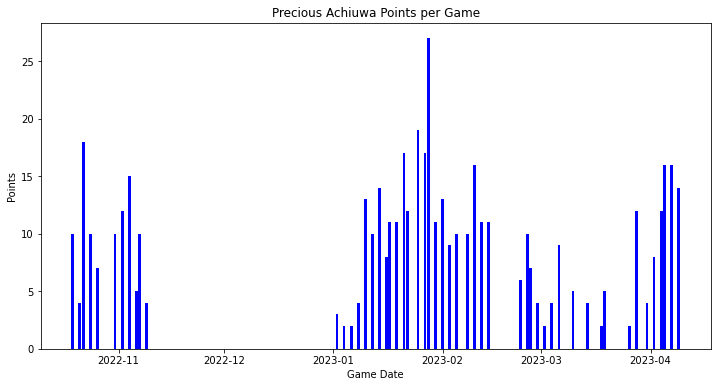

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data into a pandas dataframe
game_logs = pd.read_csv('clean_game_logs2022_2023.csv')

# Filter data by player name (example: Precious Achiuwa)
player_name = 'Precious Achiuwa'
player_logs = game_logs[game_logs['Player'] == player_name]

# Convert 'DATE' column to datetime format
player_logs.loc[:, 'DATE'] = pd.to_datetime(player_logs['DATE'])
player_logs.loc[:, 'PTS'] = player_logs['PTS'].astype(float)

# Create bar plot of points vs game date
plt.figure(figsize=(12,6))
plt.bar(player_logs['DATE'], player_logs['PTS'], color='blue')

# Set chart title and labels
plt.title(f"{player_name} Points per Game")
plt.xlabel('Game Date')
plt.ylabel('Points')

# Show plot
plt.show()

In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

game_logs = pd.read_csv('clean_game_logs2022_2023.csv')

def plot_player_points(df, player_name):
    # filter the DataFrame by player name
    player_df = df[df['Player'] == player_name]

    # Convert 'DATE' column to datetime format
    # player_df.loc[:, 'Date'] = pd.to_datetime(player_df['Date'])
    player_df.loc[:, 'PTS'] = player_df['PTS'].astype(float)

    # create a scatter plot of points by date
    fig = px.scatter(player_df, x='DATE', y='PTS', hover_data=['FG%', 'PTS', 'BLK'], color_discrete_sequence=['blue'])

    # add a cutoff line at 20 points
    cutoff_line = go.layout.Shape(
        type="line",
        xref="paper",
        yref="y",
        x0=0,
        y0=20,
        x1=1,
        y1=20,
        line=dict(color="red", width=3, dash="dash")
    )
    fig.update_layout(shapes=[cutoff_line])
    

    # filter the data based on whether the points scored are above or below 20
    filtered_above = player_df[player_df['PTS'] >= 20]
    filtered_below = player_df[player_df['PTS'] < 20]

    # add filtered traces to the plot
    fig.add_trace(go.Scatter(x=filtered_above['DATE'], y=filtered_above['PTS'], mode='markers', marker=dict(color='green'), name='Points >= 20'))
    fig.add_trace(go.Scatter(x=filtered_below['DATE'], y=filtered_below['PTS'], mode='markers', marker=dict(color='red'), name='Points < 20'))

    # format the plot
    fig.update_layout(
        title=f"Points per Game for {player_name}",
        xaxis_title="Date",
        yaxis_title="Points",
        hovermode="x"
    )

    # Summary statistics
    Over20 = len(player_df[player_df['PTS'] >= 20])/(len(player_df)-player_df['PTS'].isna().sum())
    Under20 = len(player_df[player_df['PTS'] < 20])/(len(player_df)-player_df['PTS'].isna().sum())
    text = f'% Over 20 Pts = {Over20} \n Under 20 Pts = {Under20} '
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x = 0, 
                y = 1, 
                xref = 'paper',
                yref = 'paper',
                xanchor = 'left',
                yanchor = 'top',
                text = text,
                showarrow = False,
        )]
    )
    fig.show()

# example usage
plot_player_points(game_logs, 'Jimmy Butler')

In [104]:
game_logs.to_csv('clean_game_logs2022_2023.csv',index = False)